In [ ]:
%%bash

pip -q install transformers
pip -q install datasets
pip -q install tqdm
pip -q install sentencepiece

In [ ]:
import transformers

from transformers import DistilBertModel, DistilBertConfig

import pandas as pd
import torch

In [ ]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

# Jean
os.chdir('/content/gdrive/My Drive/NLP_Project_Author_identification')

# Victor
# os.chdir('/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification')

Mounted at /content/gdrive


# File parsing and preprocessing

In [ ]:
#@title Default title text
train_df = pd.read_csv('data/train_DistilBERT.csv')
test_df = pd.read_csv('data/test_DistilBERT.csv')

import json
import random
from multiprocessing import Pool
from tqdm import tqdm, trange

create_set = False

def proc_line_init(tokenizer_for_authors):
    global tokenizer
    tokenizer = tokenizer_for_authors


# Preprocess one C50 data point
def proc_line(row, truncation = True, max_length = 512):
    article = getattr(row, 'Article')
    author = row['Author']

    article_ids = tokenizer.encode(article, verbose=False, truncation = truncation, max_length = max_length)

    author_id = author2idx[author]

    samp = {
        "Article": article,
        "Author": author,
        "article_ids": article_ids,
        "author_id": author_id,
    }

    return samp


# Preprocess SQuAD corpus with tqdm multithreading
def preproc():

    # with Pool(threads, initializer=proc_line_init, initargs=(tokenizer,)) as p:
    #     article_proc = list(tqdm(p.imap(proc_line, article_list), total=len(article_list)))
    
    # article_proc = [x for x in article_proc if x]

    article_proc = list()

    for index, row in train_df.iterrows():
      article_proc.append(proc_line(row))

    json.dump(article_proc, open("/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification/data/C50_train_enc_DistilBERT.json", 'w'))

    article_proc_test = list()
    for index, row in test_df.iterrows():
      article_proc_test.append(proc_line(row))

    json.dump(article_proc_test, open("/content/gdrive/MyDrive/6.864 - NLP/NLP_Project_Author_identification/data/C50_test_enc_DistilBERT.json", 'w'))
    
    return article_proc, article_proc_test

if create_set:
  article_proc, article_proc_test = preproc()
else:
  article_proc = json.load(open("/content/gdrive/MyDrive/NLP_Project_Author_identification/data/C50_train_enc_DistilBERT.json", 'r'))
  article_proc_test = json.load(open("/content/gdrive/MyDrive/NLP_Project_Author_identification/data/C50_test_enc_DistilBERT.json", 'r'))

# We can access to stuff inside the doc with
# article_proc[0]["article_ids"]

# Create index for the author, as well as dictionary to go from index to author
idx2author = list(train_df.Author.sort_values().unique()) # we sort values so that it's easy to re-find the order just in case
author2idx = {idx2author[i]: i for i in range(len(idx2author))}
n_authors = len(idx2author)
print(f"We have {n_authors} authors.")

We have 50 authors.


# Distill BERT


In [ ]:
#@title Default title text
lm_pretrained = transformers.AutoModel.from_pretrained('distilbert-base-cased')
tokenizer = transformers.AutoTokenizer.from_pretrained('distilbert-base-cased')
import torch.nn as nn

class ModelOutputs:
    def __init__(self, author_logits=None, loss=None):
        self.author_logits = author_logits
        self.loss = loss

class AuthorDiscoveringModel(nn.Module):

    def __init__(self, language_model=None, dropout=0.2):
        '''
        lm:         a pretrained transformer language model
        dropout:    dropout rate for the dropout layer
        '''
        super(AuthorDiscoveringModel, self).__init__()

        self.author_outputs = nn.Linear(language_model.config.dim, n_authors)
        self.language_model = language_model
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input_ids=None, attention_mask=None, author=None):
        '''
        input_ids:          ids of the concatenated input tokens
        attention_mask:     concatenated attention masks (ques+ctx)
        author:    label (idx) of the author of the articles
        '''
        
        lm_output = self.language_model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )

        last_hidden_state = lm_output.last_hidden_state # size (batch_size, seq_len, hidden_size)
        # cls token stores a sentence-level embedding, can be found at index 0
        cls_token= last_hidden_state[:, 0, :] # size (batch_size, hidden_size)
        cls_token = self.dropout(cls_token)

        author_logits = None

        # author_logits.size() should be (batch_size, n_authors)

        author_logits = self.author_outputs(cls_token)  # the linear layer converts from size (batch_size, hidden_size) to size (batch_size, n_authors)

        total_loss = None

        if author is not None:

            loss_fct = nn.CrossEntropyLoss()
            
            total_loss = loss_fct(author_logits, author)
        
        return ModelOutputs(
            author_logits = author_logits,
            loss = total_loss
            )



Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
distillBERT = AuthorDiscoveringModel(lm_pretrained)
distillBERT.load_state_dict(torch.load("/content/gdrive/MyDrive/NLP_Project_Author_identification/models/author_ID_model0_14epo.pt"))
distillBERT = distillBERT.cuda()

In [ ]:
## TODO WITH MY PARAMETERS

import torch

# Hyper-parameters: you could try playing with different settings
num_epochs = 15 # Default will be 10 epochs
learning_rate = 3e-5
weight_decay = 1e-5
eps = 1e-6
batch_size = 32
warmup_rate = 0.05
art_max_length = 512

# Calculating the number of warmup steps
num_training_cases = len(article_proc)
t_total = (num_training_cases // batch_size + 1) * num_epochs
ext_warmup_steps = int(warmup_rate * t_total)

# Initializing an AdamW optimizer
ext_optim = torch.optim.AdamW(distillBERT.parameters(), lr=learning_rate,
                              eps=eps, weight_decay=weight_decay)

# Initializing the learning rate scheduler [details are in the BERT paper]
ext_sche = transformers.get_linear_schedule_with_warmup(
    ext_optim, num_warmup_steps=ext_warmup_steps, num_training_steps=t_total
)

print("***** Training Info *****")
print("  Num examples = %d" % t_total)
print("  Num Epochs = %d" % num_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % t_total)

***** Training Info *****
  Num examples = 1770
  Num Epochs = 15
  Batch size = 32
  Total optimization steps = 1770


## DistillBERT with Attention

In [ ]:
#@title Attention Class creation
import torch.nn as nn

class ModelOutputs:
    def __init__(self, author_logits=None, loss=None):
        self.author_logits = author_logits
        self.loss = loss

class AuthorDiscoveringModel_distill_attention(nn.Module):

    def __init__(self, language_model=None, dropout=0.2, att_dim = None):
        '''
        lm:         a pretrained transformer language model
        dropout:    dropout rate for the dropout layer
        '''
        super(AuthorDiscoveringModel_distill_attention, self).__init__()

        self.author_outputs = nn.Linear(language_model.config.dim, n_authors)
        self.language_model = language_model
        self.dropout = nn.Dropout(dropout)

        if att_dim == None:
          self.attention = nn.Linear(language_model.config.dim, language_model.config.dim)
          self.context_vector = nn.Linear(language_model.config.dim, 1, bias=False)
        else:
          self.attention = nn.Linear(language_model.config.dim, att_dim)
          self.context_vector = nn.Linear(att_dim, 1, bias=False)

        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim = 1)
    
    def forward(self, input_ids=None, attention_mask=None, author=None):
        '''
        input_ids:          ids of the concatenated input tokens
        attention_mask:     concatenated attention masks (ques+ctx)
        author:    label (idx) of the author of the articles
        '''
        
        lm_output = self.language_model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )

        last_hidden_state = lm_output.last_hidden_state # size (batch_size, seq_len, hidden_size)
        last_hidden_state = self.dropout(last_hidden_state) # size (batch_size, seq_len, hidden_size)

        att = self.tanh(self.attention(last_hidden_state)) # size (batch_size, seq_len, att_dim)
        att = self.context_vector(att).squeeze(2)
        att = self.softmax(att)


        hidden_state = torch.bmm(last_hidden_state.permute(0,2,1), att.unsqueeze(2)) # size (batch_size, hidden_size)

        author_logits = None

        author_logits = self.author_outputs(hidden_state.squeeze(2))  # (batch_size, n_authors)

        total_loss = None

        if author is not None:

            loss_fct = nn.CrossEntropyLoss()
            
            total_loss = loss_fct(author_logits, author)
        
        return ModelOutputs(
            author_logits = author_logits,
            loss = total_loss
            )

In [ ]:
#@title Load bert attention - Do not work
lm_pretrained = transformers.AutoModel.from_pretrained('distilbert-base-cased')
distillBERT_attention = AuthorDiscoveringModel_distill_attention(lm_pretrained)
distillBERT_attention = distillBERT_attention.cuda()
# distillBERT_attention.load_state_dict(torch.load("/content/gdrive/MyDrive/NLP_Project_Author_identification/models/author_ID_DistilBERT_model_attention.pt"))

In [ ]:
#@title Default title text
import torch

# Hyper-parameters: you could try playing with different settings
num_epochs = 20 # Default is 10 epochs
learning_rate = 3e-5 
weight_decay = 1e-5
eps = 1e-6
batch_size = 32
warmup_rate = 0.05
art_max_length = 512

# Calculating the number of warmup steps
num_training_cases = len(article_proc)
t_total = (num_training_cases // batch_size + 1) * num_epochs
ext_warmup_steps = int(warmup_rate * t_total)

# Initializing an AdamW optimizer
ext_optim = torch.optim.AdamW(distillBERT_attention.parameters(), lr=learning_rate,
                              eps=eps, weight_decay=weight_decay)

# Initializing the learning rate scheduler [details are in the BERT paper]
ext_sche = transformers.get_linear_schedule_with_warmup(
    ext_optim, num_warmup_steps=ext_warmup_steps, num_training_steps=t_total
)

print("***** Training Info *****")
print("  Num examples = %d" % t_total)
print("  Num Epochs = %d" % num_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % t_total)

In [ ]:
def logits_to_author(author_logits):
  '''
  Input sizes:
      author_logits.size() = (batch_size, n_author)
  Output sizes:
      author_pred.size() = (batch_size,)
  '''

  author_id = torch.argmax(author_logits, axis=1, keepdims=True)

  return author_id


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true,y_pred,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''

    cf=confusion_matrix(y_true,y_pred)
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)
    plt.show()

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    
    if title:
        plt.title(title)

def find_variance(y_true, y_pred,plot):
  dict_author={}
  for k in list(set(y_true)):
    list_index=[i for i in range(len(y_true)) if y_true[i]==k]
    nb_author=len(list_index)
    nb_correct=len([y_true[j] for j in list_index if y_true[j]==y_pred[j]])
    dict_author[k]=nb_correct/nb_author
  if plot:
    plt.hist(dict_author.values())
    plt.show()
  return np.var(list(dict_author.values())),dict_author



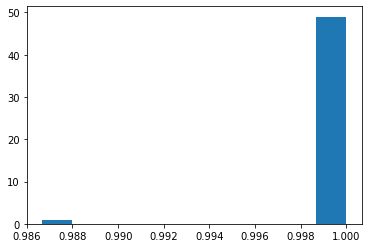

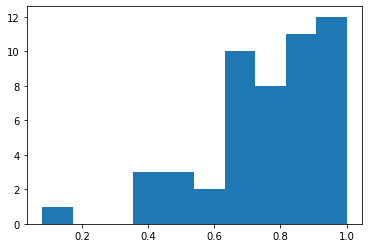

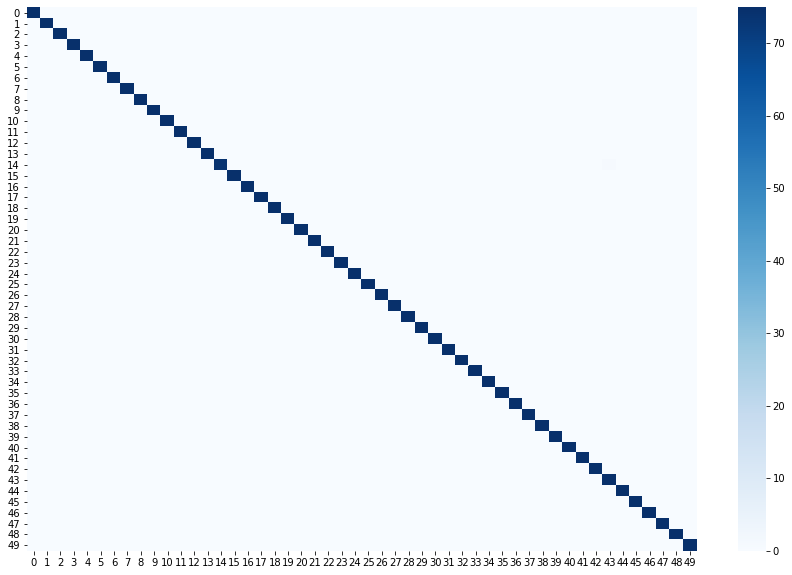

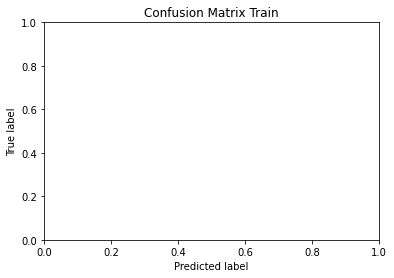

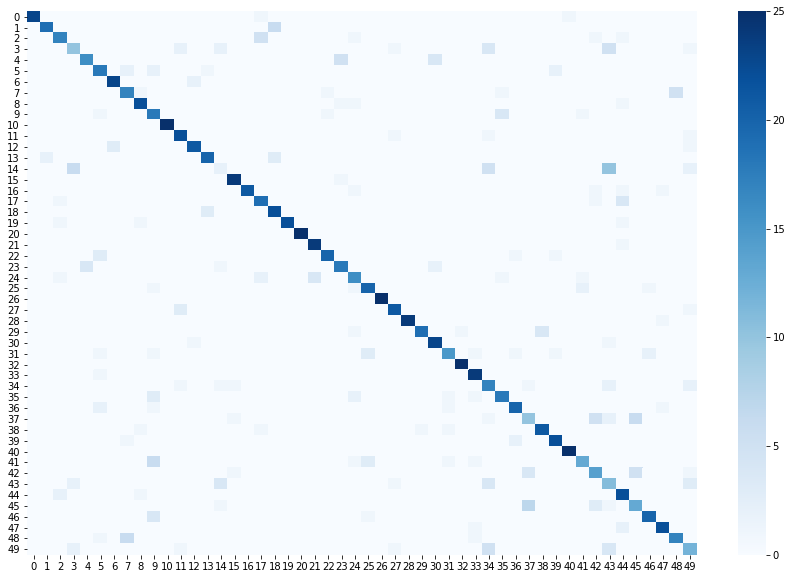

({'AaronPressman': 1.0,
  'AlanCrosby': 1.0,
  'AlexanderSmith': 1.0,
  'BenjaminKangLim': 1.0,
  'BernardHickey': 1.0,
  'BradDorfman': 1.0,
  'DarrenSchuettler': 1.0,
  'DavidLawder': 1.0,
  'EdnaFernandes': 1.0,
  'EricAuchard': 1.0,
  'FumikoFujisaki': 1.0,
  'GrahamEarnshaw': 1.0,
  'HeatherScoffield': 1.0,
  'JanLopatka': 1.0,
  'JaneMacartney': 0.9866666666666667,
  'JimGilchrist': 1.0,
  'JoWinterbottom': 1.0,
  'JoeOrtiz': 1.0,
  'JohnMastrini': 1.0,
  'JonathanBirt': 1.0,
  'KarlPenhaul': 1.0,
  'KeithWeir': 1.0,
  'KevinDrawbaugh': 1.0,
  'KevinMorrison': 1.0,
  'KirstinRidley': 1.0,
  'KouroshKarimkhany': 1.0,
  'LydiaZajc': 1.0,
  "LynneO'Donnell": 1.0,
  'LynnleyBrowning': 1.0,
  'MarcelMichelson': 1.0,
  'MarkBendeich': 1.0,
  'MartinWolk': 1.0,
  'MatthewBunce': 1.0,
  'MichaelConnor': 1.0,
  'MureDickie': 1.0,
  'NickLouth': 1.0,
  'PatriciaCommins': 1.0,
  'PeterHumphrey': 1.0,
  'PierreTran': 1.0,
  'RobinSidel': 1.0,
  'RogerFillion': 1.0,
  'SamuelPerry': 1.0,
  'S

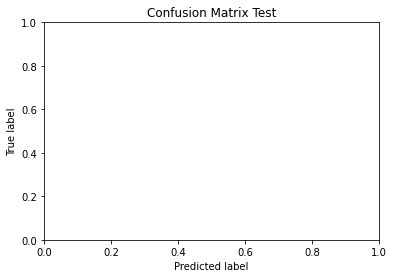

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support


def eval_model(model_name,plot): #If plot=False, no plot will be displayed
  df=pd.read_csv('Models_outputs/output_'+model_name+'.csv')
  df_train=df[df['train']==1].reset_index(drop=True)
  df_test=df[df['train']==0].reset_index(drop=True)
  author_pred_train=df_train['author_pred']
  author_gt_train=df_train['author_gt']
  author_pred_test=df_test['author_pred']
  author_gt_test=df_test['author_gt']
  accuracy_train = accuracy_score(author_gt_train,author_pred_train)
  accuracy_test = accuracy_score(author_gt_test,author_pred_test)
  precision_train,recall_train,f1_score_train,support_train=precision_recall_fscore_support(author_gt_train,author_pred_train,average='macro')
  precision_test,recall_test,f1_score_test,support_test=precision_recall_fscore_support(author_gt_test,author_pred_test,average='macro')
  out_var_train=find_variance(author_gt_train, author_pred_train,plot)
  out_var_test=find_variance(author_gt_test, author_pred_test,plot)
  variance_train=out_var_train[0]
  variance_test=out_var_test[0]
  df_results=pd.DataFrame(index=[model_name+'_train',model_name+'_test'],columns=['Accuracy','Precision','Recall','F1_score','Accuracy_variance'])
  df_results.loc[model_name+'_train',:]=[accuracy_train,precision_train,recall_train,f1_score_train,variance_train]
  df_results.loc[model_name+'_test',:]=[accuracy_test,precision_test,recall_test,f1_score_test,variance_test]
  df_results.to_excel('Results/Results_'+model_name+'.xlsx')
  if plot:
    make_confusion_matrix(author_gt_train,author_pred_train,figsize=(15,10),count=False,percent=False,title='Confusion Matrix Train')
    make_confusion_matrix(author_gt_test,author_pred_test,figsize=(15,10),count=False,percent=False,title='Confusion Matrix Test')
  dict_author_train=out_var_train[1]
  dict_author_test=out_var_test[1]
  return dict_author_train,dict_author_test


# def create_dataframe(model_name,model):
#   df_results=pd.DataFrame(index=[model_name+'_train',model_name+'_test'],columns=['Accuracy','Precision','Recall','F1_score','Accuracy_variance'])
#   eval_train=eval_model(article_proc,model,True)
#   eval_test=eval_model(article_proc_test,model,True)
#   df_results.loc[model_name+'_train',:]=eval_train[0]
#   df_results.loc[model_name+'_test',:]=eval_test[0]
#   df_results.to_excel('Results/Results_'+model_name+'.xlsx')
#   return eval_test[1]

eval_model('author_ID_model3',True)

# Analysis of Authors that work well and badly



In [ ]:
from operator import itemgetter
dict_author=eval_model('author_ID_model3',False)[1]

worst_author=dict(sorted(dict_author.items(), key = itemgetter(1), reverse = True)[-3:]).keys()
best_author=dict(sorted(dict_author.items(), key = itemgetter(1), reverse = True)[:3]).keys()

In [ ]:
dict_best=d = dict.fromkeys(best_author, [])
dict_worst=d = dict.fromkeys(worst_author, [])
for k in range(len(article_proc_test)):
  if article_proc_test[k]['Author'] in worst_author:
    dict_worst[article_proc_test[k]['Author']]=dict_worst[article_proc_test[k]['Author']]+[article_proc_test[k]['Article']]
  if article_proc_test[k]['Author'] in best_author:
    dict_best[article_proc_test[k]['Author']]=dict_best[article_proc_test[k]['Author']]+[article_proc_test[k]['Article']]

len(dict_best[list(best_author)[0]])

25

In [ ]:
#Vocabulary Richness with Yule Method

from nltk.stem.porter import PorterStemmer
from itertools import groupby

def words(entry):
    return filter(lambda w: len(w) > 0,
                  [w.strip("0123456789!:,.?(){}[]") for w in entry.split()])

def yule(entry):
    # yule's I measure (the inverse of yule's K measure)
    # higher number is higher diversity - richer vocabulary
    d = {}
    stemmer = PorterStemmer()
    for w in words(entry):
        w = stemmer.stem(w).lower()
        try:
            d[w] += 1
        except KeyError:
            d[w] = 1

    M1 = float(len(d))
    M2 = sum([len(list(g))*(freq**2) for freq,g in groupby(sorted(d.values()))])

    try:
        return (M1*M1)/(M2-M1)
    except ZeroDivisionError:
        return 0

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer

list_acc=[]
list_yule=[]
list_words_weight=[]
list_text=[]
dict_text=dict.fromkeys(dict_author.keys(),[])
for k in range(len(article_proc_test)):
  dict_text[article_proc_test[k]['Author']]=dict_text[article_proc_test[k]['Author']]+[article_proc_test[k]['Article']]

for author in dict_text.keys():
  text=''.join(dict_text[author])
  list_text.append(text)
  list_acc.append(dict_author[author])
  list_yule.append(yule(text))

tfidf_vectorizer = TfidfVectorizer(max_features= 1000000)
tfidf_vectorizer.fit_transform(list_text)
for author in dict_text.keys():
  text=''.join(dict_text[author])
  list_words_weight.append(np.sum(np.sort(np.array(tfidf_vectorizer.transform([text]).todense())[0])[-10:]))

def weight_max_words(text):
  return(np.sum(np.sort(np.array(tfidf_vectorizer.transform([text]).todense())[0])[-10:]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


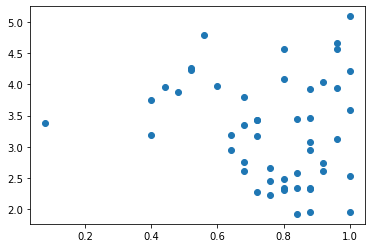

[[ 1.         -0.40670044]
 [-0.40670044  1.        ]]


array([[ 1.        , -0.14457218],
       [-0.14457218,  1.        ]])

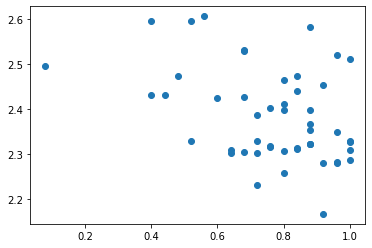

In [ ]:
plt.scatter(list_acc,list_yule)
plt.show()
plt.scatter(list_acc,list_words_weight)
print(np.corrcoef(list_acc,list_words_weight))
np.corrcoef(list_acc,list_yule)

# Features Creation to understand what our model does

In [ ]:
# Sentences lengths, words lengths and vocabulary diversity
def find_avg_sentence_len(text):
  return len(text.split(' '))/(len(text.split('.'))-1)

def find_avg_word_len(text):
  return len(''.join(filter(str.isalpha, text)))/len(text.split(' '))

def find_pct_numbers(text):
  return sum(c.isdigit() for c in text)/len(text)

def find_text_len(text):
  return len(text.split(' '))
#Vocabulary Richness with Yule Method

from nltk.stem.porter import PorterStemmer
from itertools import groupby

def words(entry):
    return filter(lambda w: len(w) > 0,
                  [w.strip("0123456789!:,.?(){}[]") for w in entry.split()])

def yule(entry):
    # yule's I measure (the inverse of yule's K measure)
    # higher number is higher diversity - richer vocabulary
    d = {}
    stemmer = PorterStemmer()
    for w in words(entry):
        w = stemmer.stem(w).lower()
        try:
            d[w] += 1
        except KeyError:
            d[w] = 1

    M1 = float(len(d))
    M2 = sum([len(list(g))*(freq**2) for freq,g in groupby(sorted(d.values()))])

    try:
        return (M1*M1)/(M2-M1)
    except ZeroDivisionError:
        return 0




In [ ]:
import spacy
sp = spacy.load('en_core_web_sm')

sen = sp(u"I like to play football. I hated it in my childhood though")

num_pos = sen.count_by(spacy.attrs.POS)
num_pos

def compute_pos(text):
  sen = sp(text)
  num_pos = sen.count_by(spacy.attrs.POS)
  for k,v in sorted(num_pos.items()):
    num_pos[sen.vocab[k].text] = num_pos.pop(k)
  return(num_pos)

def count_nb_entities(text):
  dict_ent={}
  entities=sp(text).ents
  for ent in entities:
    if ent.label_ in dict_ent.keys():
      dict_ent[ent.label_]+=1
    else:
      dict_ent[ent.label_]=1

  return(dict_ent)

count_nb_entities('Victor Russia likes sausage at Donald Trump')

{'GPE': 1, 'PERSON': 1}

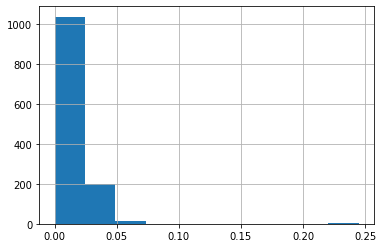

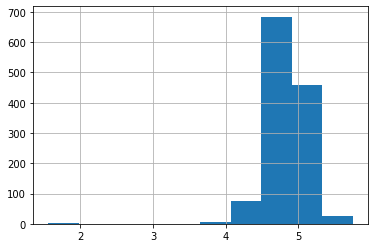

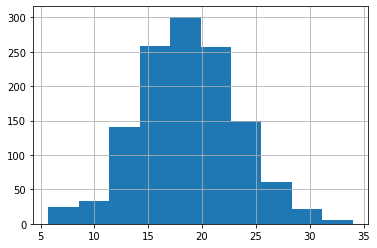

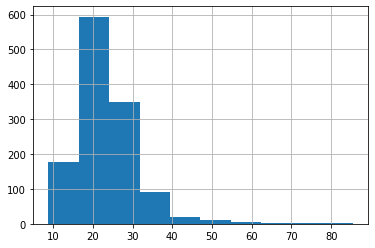

In [ ]:
def create_dataframe(model_name):
  df=pd.DataFrame()
  df_res=pd.read_csv('Models_outputs/output_'+model_name+'.csv')
  df_train=df_res[df_res['train']==1].reset_index(drop=True)
  df_test=df_res[df_res['train']==0].reset_index(drop=True)
  df['Text']=pd.read_csv('data/test_DistilBERT.csv')['Article'].values
  df['Author']=pd.read_csv('data/test_DistilBERT.csv')['Author'].values
  df['Predicted_Author']=df_test['author_pred']
  df['output']=1*(df['Author']==df['Predicted_Author'])
  df['Pct_number']=df['Text'].apply(lambda x:find_pct_numbers(x))
  df['Pct_number'].hist()
  plt.show()
  df['Word_Len']=df['Text'].apply(lambda x:find_avg_word_len(x))
  df['Word_Len'].hist()
  plt.show()
  df['Sentence_Len']=df['Text'].apply(lambda x:find_avg_sentence_len(x))
  df['Sentence_Len'].hist()
  plt.show()
  df['Voc_richness']=df['Text'].apply(lambda x:yule(x))
  df['Voc_richness'].hist()
  plt.show()
  df['POS']=df['Text'].apply(lambda x:compute_pos(x))
  df['Entities']=df['Text'].apply(lambda x:count_nb_entities(x))
  df['weight_max_words']=df['Text'].apply(lambda x:weight_max_words(x))
  df['text_len']=df['Text'].apply(lambda x: find_text_len(x))
  df=pd.concat([df.drop(['POS','Entities'],axis=1),df['POS'].apply(pd.Series).drop(['SPACE','SYM','X','INTJ'],axis=1).divide(df['text_len'],axis=0),df['Entities'].apply(pd.Series)[['DATE','CARDINAL','GPE','ORG','PERSON','NORP','MONEY','PERCENT']].divide(df['text_len'],axis=0)],axis=1).fillna(0)
  return df

df=create_dataframe('author_ID_model3')

In [ ]:
pd.read_csv('data/test_DistilBERT.csv')


,Author,Article
0,ToddNissen,Federal investigators said on Sunday an examin...
1,ToddNissen,National Transportation Safety Board (NTSB) in...
2,ToddNissen,Workers striking two Johnson Control Inc. seat...
3,ToddNissen,Investigators of Thursday's Delta Comair crash...
4,ToddNissen,Ford Motor Co's long-shot bid to sit down firs...
...,...,...
1245,AlexanderSmith,"Lawyers acting for Peter Young, the fund manag..."
1246,AlexanderSmith,NatWest Bank admitted on Thursday that its mu...
1247,AlexanderSmith,The head of Britain's financial markets watchd...
1248,AlexanderSmith,British property group Hammerson Plc's chief e...


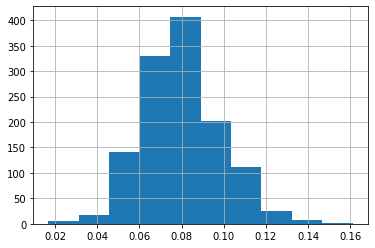

In [ ]:
df['POS'].apply(pd.Series).drop(['SPACE','SYM','X','INTJ'],axis=1).fillna(0).divide(df['text_len'],axis=0)['ADJ'].hist()

In [ ]:
import statsmodels.api as sm
normalized_df=pd.concat([(df.drop('output',axis=1)-df.drop('output',axis=1).mean())/df.drop('output',axis=1).std(),df['output']],axis=1)
y=normalized_df['output']
X=sm.add_constant(normalized_df.drop(['output','Text','Author','Predicted_Author'],axis=1))

model2=sm.OLS(y,X).fit_regularized('elastic_net', L1_wt=1.0,refit=True,zero_tol=0.0)
# model.summary()
list_col=[]
for k in range(1,len(X.columns)):
  if model.params[k]!=0:
    list_col.append(normalized_df.drop(['output','Text','Author','Predicted_Author'],axis=1).columns[k-1])

X=sm.add_constant(normalized_df[list_col])

model2=sm.OLS(y,X).fit_regularized('elastic_net', L1_wt=1.0,refit=True,zero_tol=0.02)
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 output   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     8.155
Date:                Thu, 20 May 2021   Prob (F-statistic):           8.56e-11
Time:                        19:39:12   Log-Likelihood:                -668.04
No. Observations:                1250   AIC:                             1354.
Df Residuals:                    1242   BIC:                             1400.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7656      0.012     65.343      0.000       0.743       0.789
ADP           -0.0320      0.013     -2.501      0.013      -0.057      -0.007
CCONJ         -0.0333      0.012     -2.758      0.006      -0.057      -0.010
GPE           -0.0572      0.014     -4.149      0.000      -0.084      -0.030
NOUN           0.0315      0.014      2.202      0.028       0.003       0.060
PART          -0.0288      0.013     -2.294      0.022      -0.054      -0.004
PERSON        -0.0385      0.013     -3.055      0.002      -0.063      -0.014
PROPN          0.0422      0.015      2.845      0.005       0.013       0.071
==============================================================================
Omnibus:                      199.971   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              301.092
Skew:                          -1.194   Prob(JB):                     4.16e-66
Kurtosis:                       2.714   Cond. No.                         2.27
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
X

,const,ADJ,ADP,ADV,AUX,CARDINAL,CCONJ,DATE,DET,GPE,MONEY,NORP,NOUN,NUM,ORG,PART,PERCENT,PERSON,PRON,PROPN,PUNCT,Pct_number,SCONJ,Sentence_Len,VERB,Voc_richness,Word_Len,text_len,weight_max_words
0,1.0,-1.128051,2.044848,-1.235334,-1.457016,-0.138807,-0.087022,0.078858,1.963324,-0.080128,-0.842895,-0.793539,1.333027,-0.497417,-0.644690,-2.015864,-0.713610,-0.626727,-0.174732,-0.254831,-1.037755,-0.492432,-1.417253,1.127386,-0.340368,-0.522119,0.465434,-0.800201,-1.262135
1,1.0,-2.492151,0.473763,-0.707110,0.740219,0.473173,-0.782902,0.373105,1.434694,0.633996,-0.842895,-0.258688,-0.192330,0.137866,0.501759,-1.596885,-0.713610,0.098896,-1.133359,1.486726,-0.511916,0.284495,-0.974723,0.208401,-0.373773,0.511387,-0.098483,-0.303552,-1.200735
2,1.0,-0.032456,0.047866,-0.751481,-0.553586,0.380376,-1.675967,-0.899751,0.350640,0.232345,-0.105804,-0.793539,0.549692,-0.584802,1.395368,0.151045,-0.713610,-0.020563,-0.696723,0.608112,-0.344090,-0.366805,-0.871875,-0.645400,0.964020,0.159171,-0.271454,-0.536826,0.295854
3,1.0,-1.866973,-0.686164,0.743081,1.164804,0.318160,-0.473895,-1.141914,-0.052676,-0.200294,-0.842895,-0.520325,0.529642,0.336715,-1.115652,-0.976596,-0.713610,0.130198,2.022434,-0.854408,0.793411,0.256107,-0.943054,-0.050283,1.182093,0.227769,0.310749,-0.378802,-1.812453
4,1.0,-1.326268,-2.048042,-0.582896,3.156774,-0.658621,-0.350547,-0.542045,0.196537,-0.851616,-0.842895,-0.793539,-0.977716,-1.171102,1.346838,2.575678,-0.713610,-0.228573,1.073747,-0.191660,0.286781,-0.912500,0.731189,-0.006996,1.246979,0.181805,-0.965240,0.080222,0.525962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,1.0,-1.292432,0.587543,-0.810982,3.155388,-0.343657,1.125122,0.102571,-0.245727,-0.856548,0.169744,-0.321671,-1.247692,-0.345121,0.973271,-0.763331,-0.713610,-0.435931,1.151646,0.354184,-0.084125,-0.585169,-0.630692,0.406829,0.551516,-0.423012,0.381280,0.170522,-1.233968
1246,1.0,-1.100889,-0.364685,0.852263,0.062852,-0.159229,0.799068,-0.707847,-0.186145,-0.629196,-0.009415,-0.550799,-0.191273,0.192506,0.414126,-1.564467,-0.713610,0.527976,-0.609040,0.786865,-1.474844,-0.153037,-0.047349,1.073762,0.043534,-1.204585,0.794859,0.057647,-0.462903
1247,1.0,-1.244433,0.052272,1.621165,3.176793,0.285083,-1.290493,-0.971079,-0.086923,-0.586272,-0.157121,0.005353,-2.754379,-0.341008,1.071719,1.067172,-0.713610,0.915683,3.613506,-0.327133,-0.623093,-0.462028,3.389851,1.359550,-0.173483,-0.111952,-1.132218,-0.288502,0.954501
1248,1.0,-0.096064,-0.256339,0.365474,1.419677,0.785933,-1.339585,1.422531,-0.566779,-0.598253,0.048894,1.284237,-0.272608,1.620866,-0.913313,-1.268947,2.102395,1.461736,1.816102,-1.319178,0.301142,0.775210,-0.732681,-0.962770,0.212259,-0.202777,-1.356122,-2.026774,-0.343900


In [ ]:
from sklearn.linear_model import LinearRegression

model=LinearRegression()
model.fit(np.array(df.drop(['output','Text','Author','Predicted_Author'],axis=1)),np.array(y))

model.score(np.array(df.drop(['output','Text','Author','Predicted_Author'],axis=1)),np.array(y))

0.053619521669379555